In [1]:
# !pip install torch
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
from torchvision import datasets, models, transforms
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LandmarkImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, id_path_mapping=""):
        """
        Args:
            annotations_file (string): Path to the CSV file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            file_extension (string, optional): Extension of the image files in the directory.
        """
        self.img_labels = pd.read_csv(annotations_file)
        self.id_to_label = {str(row[0]): row[3] for row in self.img_labels.values}
        self.transform = transform
        self.id_path_mapping = pd.read_csv(id_path_mapping)
        self.length = len(self.id_path_mapping)


    def __len__(self):
        return self.length

    def __getitem__(self, idx):

        # Retrieve the image ID and path from the mapping
        image_id = self.id_path_mapping.iloc[idx]['id']
        image_path = self.id_path_mapping.iloc[idx]['path']

        # Load the image
        image = Image.open(image_path)

        # Retrieve the label
        label = self.id_to_label[str(image_id)]

        # Apply transform if any
        if self.transform:
            image = self.transform(image)

        return image, label


# Define transformations for the training data
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

label_csv = "/Users/ruipenghan/Desktop/Academics/11. SP 2024/CS 444/project/small_data/small_data.csv"
train_img_id_to_path_mapping = "/Users/ruipenghan/Desktop/Academics/11. SP 2024/CS 444/project/small_data/train_img_id_to_path_mapping.csv"
# Create an instance of the dataset
train_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=train_img_id_to_path_mapping
)

# Define the DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)



In [15]:
len(train_dataset)

6720

# Model Initialization

In [16]:
from torchvision import models
import torch

def initialize_model(num_classes):
    # Load a pretrained ResNet-18 model
    model = models.resnet18(pretrained=True)
    # Modify the final layer to match the number of classes
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, num_classes)
    return model

# Determine the number of unique classes
num_classes = len(set(train_dataset.id_to_label.values()))

# num_classes=2000
print(f"number of classes {num_classes}")
model = initialize_model(num_classes=num_classes)



number of classes 25


/Users/ruipenghan/Desktop/Academics/11. SP 2024/CS 444/project/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ruipenghan/Desktop/Academics/11. SP 2024/CS 444/project/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

def train_model(model, train_loader, loss_fn, optimizer, device, epochs=10):
    model.to(device)
    train_losses = []
    train_accuracies = []
    best_train_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Wrap the training loop with tqdm for a progress bar
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            # Update the progress bar with current loss and accuracy
            progress_bar.set_postfix(loss=f'{running_loss / total_samples:.4f}', acc=f'{(correct_predictions.double() / total_samples * 100):.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_predictions.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}, Accuracy: {epoch_acc}')

        # Save the best model if the training loss has improved
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            torch.save(model.state_dict(), 'saved_models/resnet-18_best_model.pth')
            print(f'Saved best model with Train Loss: {epoch_loss}')

    return train_losses, train_accuracies



In [37]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies):
    plt.figure(figsize=(10, 5))
    
    # Create the first axis for the training loss
    ax1 = plt.gca()  # Get current axis
    line1, = ax1.plot(train_losses, label='Training Loss', color='red', marker='o')
    ax1.set_xlabel('Epochs')  # Common x-axis label
    ax1.set_ylabel('Loss', color='red')  # Set y-axis label for loss
    ax1.tick_params(axis='y', labelcolor='red')  # Set the color of y-axis ticks to red

    # Create a second y-axis for the training accuracy using twinx()
    ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
    line2, = ax2.plot(train_accuracies, label='Training Accuracy', color='blue', marker='x')
    ax2.set_ylabel('Accuracy', color='blue')  # Set y-axis label for accuracy
    ax2.tick_params(axis='y', labelcolor='blue')  # Set the color of y-axis ticks to blue
    
    # Title and grid
    plt.title('Training Loss and Accuracy')
    ax1.grid(True)

    # Create legends and position them appropriately
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc='center right')  # Position the legend in the center right

    plt.show()




In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  print("CUDA USED")
else:
  print("CPU USED")

CPU USED


In [22]:
# Initialize the model, optimizer, and loss function
model = initialize_model(num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# Move the model to the appropriate device
model.to(device)

# Train the model
train_losses, train_accuracies = train_model(model, train_loader, loss_fn, optimizer, device, epochs=30)

/Users/ruipenghan/Desktop/Academics/11. SP 2024/CS 444/project/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ruipenghan/Desktop/Academics/11. SP 2024/CS 444/project/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saved best model with Train Loss: 2.347551160625049


Saved best model with Train Loss: 1.9502164392244248


Saved best model with Train Loss: 1.7380145281553268


Saved best model with Train Loss: 1.5923232630959578


Saved best model with Train Loss: 1.5262392115380083


Saved best model with Train Loss: 1.439361092093445


Saved best model with Train Loss: 1.3659828203419844


Saved best model with Train Loss: 1.3010913262587218


Saved best model with Train Loss: 1.2450960708870775


Saved best model with Train Loss: 1.1893500992673494


Saved best model with Train Loss: 1.1068601301826893


Saved best model with Train Loss: 1.0710590379578726


Saved best model with Train Loss: 1.0314172055838364


Saved best model with Train Loss: 0.9509064637612374


Saved best model with Train Loss: 0.8888272951246194


Saved best model with Train Loss: 0.8429659724457278


Saved best model with Train Loss: 0.7916924219423284


Saved best model with Train Loss: 0.7433071149402254


Saved best model with Train Loss: 0.7074023700773805


Saved best model with Train Loss: 0.6530557313290912


Saved best model with Train Loss: 0.6046025251670342


Saved best model with Train Loss: 0.5588101159764587


Saved best model with Train Loss: 0.506058759708789


Saved best model with Train Loss: 0.44924077979507965


Saved best model with Train Loss: 0.42792418910844604


Saved best model with Train Loss: 0.3820645362275952


Saved best model with Train Loss: 0.36174190848722076


Saved best model with Train Loss: 0.3371616340605431


Saved best model with Train Loss: 0.3092662789984994


Saved best model with Train Loss: 0.26960419553326487


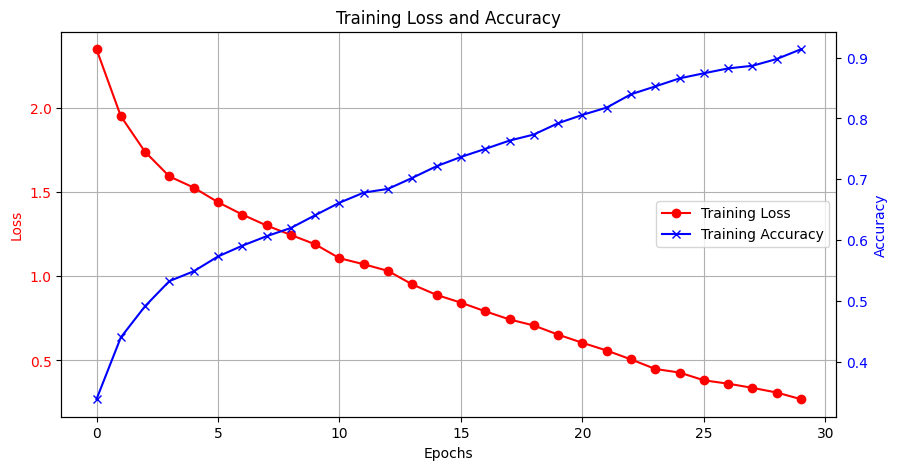

Max Accuracy: 0.9138392857142857


In [38]:
# Plot losses
plot_metrics(train_losses, train_accuracies)
print(f"Max Accuracy: {max(train_accuracies)}")

# Test and Eavluation

In [39]:
def evaluate_model(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0  # Track total samples processed

    with torch.no_grad():
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Evaluating", leave=False)
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            # Update the progress bar with average loss and accuracy
            average_loss = running_loss / total_samples
            average_accuracy = correct_predictions.double() / total_samples
            progress_bar.set_postfix({'avg_loss': f'{average_loss:.4f}', 'avg_acc': f'{average_accuracy:.2f}'})

    total_loss = running_loss / len(dataloader)
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    print(f'Validation Loss: {total_loss}, Accuracy: {accuracy}')
    return total_loss, accuracy  # Optionally return metrics for further analysis


In [46]:
# Define transformations for the training data
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


label_csv = "/Users/ruipenghan/Desktop/Academics/11. SP 2024/CS 444/project/small_data/small_data.csv"
test_img_id_to_path_mapping = "/Users/ruipenghan/Desktop/Academics/11. SP 2024/CS 444/project/small_data/test_img_id_to_path_mapping.csv"
# Create an instance of the dataset
test_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=test_img_id_to_path_mapping
)

# Define the DataLoader
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False)

model.to(device)
model_path = "/Users/ruipenghan/Desktop/Academics/11. SP 2024/CS 444/project/models/baselines/saved_models/resnet-18_best_model.pth"
model.load_state_dict(torch.load(model_path))

# Evaluate the model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn, device)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Validation Loss: 1.662986279260554, Accuracy: 0.6487935656836461
Test Loss: 1.662986279260554, Test Accuracy: 0.6487935656836461


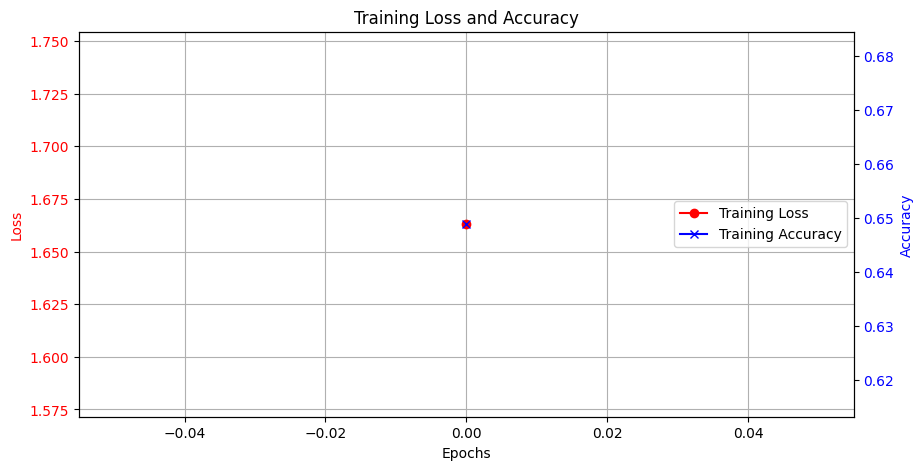

In [47]:
plot_metrics(test_loss, test_accuracy)